### import

In [ ]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.cuda.amp import autocast

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

### Tools

In [ ]:
ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# classifier free guidance functions

def uniform(shape, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob


# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

### Building block modules

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, classes_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(int(time_emb_dim) + int(classes_emb_dim), dim_out * 2)
        ) if exists(time_emb_dim) or exists(classes_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None, class_emb = None):

        scale_shift = None
        if exists(self.mlp) and (exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)




### Add attention model in block

In [ ]:
class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

### Conditional Unet model

In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        num_classes,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # classifier free guidance stuff

        self.cond_drop_prob = cond_drop_prob

        # determine dimensions

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # class embeddings

        self.classes_emb = nn.Embedding(num_classes, dim)
        self.null_classes_emb = nn.Parameter(torch.randn(dim))

        classes_dim = dim * 4

        self.classes_mlp = nn.Sequential(
            nn.Linear(dim, classes_dim),
            nn.GELU(),
            nn.Linear(classes_dim, classes_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        print(in_out)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        rescaled_phi = 0.,
        **kwargs
    ):
        logits = self.forward(*args, cond_drop_prob = 0., **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        scaled_logits = null_logits + (logits - null_logits) * cond_scale

        if rescaled_phi == 0.:
            return scaled_logits

        std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
        rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))

        return rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

    def forward(
        self,
        x,
        time,
        classes,
        cond_drop_prob = None
    ):
        batch, device = x.shape[0], x.device

        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)

        # derive condition, with condition dropout for classifier free guidance

        classes_emb = self.classes_emb(classes)

        if cond_drop_prob > 0:
            keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
            null_classes_emb = repeat(self.null_classes_emb, 'd -> b d', b = batch)

            classes_emb = torch.where(
                rearrange(keep_mask, 'b -> b 1'),
                classes_emb,
                null_classes_emb
            )

        c = self.classes_mlp(classes_emb)

        # unet

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t, c)
        return self.final_conv(x)

### Gaussian diffusion

In [ ]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [ ]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 1.,
        offset_noise_strength = 0.,
        min_snr_loss_weight = False,
        min_snr_gamma = 5
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not model.random_or_learned_sinusoidal_cond

        self.model = model
        self.channels = self.model.channels

        self.image_size = image_size

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # offset noise strength - 0.1 was claimed ideal

        self.offset_noise_strength = offset_noise_strength

        # loss weight

        snr = alphas_cumprod / (1 - alphas_cumprod)

        maybe_clipped_snr = snr.clone()
        if min_snr_loss_weight:
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if objective == 'pred_noise':
            loss_weight = maybe_clipped_snr / snr
        elif objective == 'pred_x0':
            loss_weight = maybe_clipped_snr
        elif objective == 'pred_v':
            loss_weight = maybe_clipped_snr / (snr + 1)

        register_buffer('loss_weight', loss_weight)

    @property
    def device(self):
        return self.betas.device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, classes, cond_scale = 6., rescaled_phi = 0.7, clip_x_start = False):
        model_output = self.model.forward_with_cond_scale(x, t, classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, classes, cond_scale, rescaled_phi, clip_denoised = True):
        preds = self.model_predictions(x, t, classes, cond_scale, rescaled_phi)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, classes, cond_scale = 6., rescaled_phi = 0.7, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, classes = classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, classes, shape, cond_scale = 6., rescaled_phi = 0.7):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            img, x_start = self.p_sample(img, t, classes, cond_scale, rescaled_phi)

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, classes, shape, cond_scale = 6., rescaled_phi = 0.7, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, classes, cond_scale = 6., rescaled_phi = 0.7):
        batch_size, image_size, channels = classes.shape[0], self.image_size, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn(classes, (batch_size, channels, image_size, image_size), cond_scale, rescaled_phi)

    @torch.no_grad()
    def interpolate(self, x1, x2, classes, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device = device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            img, _ = self.p_sample(img, i, classes)

        return img

    @autocast(enabled = False)
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        if self.offset_noise_strength > 0.:
            offset_noise = torch.randn(x_start.shape[:2], device = self.device)
            noise += self.offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, *, classes, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # predict and take gradient step

        model_out = self.model(x, t, classes)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = normalize_to_neg_one_to_one(img)
        return self.p_losses(img, t, *args, **kwargs)

# example
'''
if __name__ == '__main__':
    num_classes = 10

    model = Unet(
        dim = 64,
        dim_mults = (1, 2, 4, 8),
        num_classes = num_classes,
        cond_drop_prob = 0.5
    )

    diffusion = GaussianDiffusion(
        model,
        image_size = 128,
        timesteps = 1000
    ).cuda()

    training_images = torch.randn(8, 3, 128, 128).cuda() # images are normalized from 0 to 1
    image_classes = torch.randint(0, num_classes, (8,)).cuda()    # say 10 classes

    loss = diffusion(training_images, classes = image_classes)
    loss.backward()

    # do above for many steps

    sampled_images = diffusion.sample(
        classes = image_classes,
        cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
    )

    sampled_images.shape # (8, 3, 128, 128)

    # interpolation

    interpolate_out = diffusion.interpolate(
        training_images[:1],
        training_images[:1],
        image_classes[:1]
    )
'''

"\nif __name__ == '__main__':\n    num_classes = 10\n\n    model = Unet(\n        dim = 64,\n        dim_mults = (1, 2, 4, 8),\n        num_classes = num_classes,\n        cond_drop_prob = 0.5\n    )\n\n    diffusion = GaussianDiffusion(\n        model,\n        image_size = 128,\n        timesteps = 1000\n    ).cuda()\n\n    training_images = torch.randn(8, 3, 128, 128).cuda() # images are normalized from 0 to 1\n    image_classes = torch.randint(0, num_classes, (8,)).cuda()    # say 10 classes\n\n    loss = diffusion(training_images, classes = image_classes)\n    loss.backward()\n\n    # do above for many steps\n\n    sampled_images = diffusion.sample(\n        classes = image_classes,\n        cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically\n    )\n\n    sampled_images.shape # (8, 3, 128, 128)\n\n    # interpolation\n\n    interpolate_out = diffusion.interpolate(\n        trainin

### Dataset

In [ ]:
!pip install -q -U einops datasets tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
image_size = 48
channels = 1
batch_size = 32

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
num_classes = 10 #[0,1,2,3,4,5,6,7,8,9]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
#len(num_classes)

### 將dataset image 轉換成torch.Tensor數值

In [ ]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize,Grayscale

In [ ]:

from torch.utils.data import DataLoader

In [ ]:
import torch
from torchvision import transforms
from datasets import load_dataset  # Hugging Face 的 datasets 模組

# 載入 MNIST 數據集
#dataset = load_dataset("mnist")

# 定義轉換
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48))
])

# 轉換數據集中的圖像數據為 Tensor 格式
training_images = [ (transform(example['image']),example['label']) for example in dataset["train"] ]



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# 將列表轉換為一個包含所有 Tensor 的 Tensor
#training_images = torch.stack(training_images)

# 創建 DataLoader，指定 batch_size
dataloader = torch.utils.data.DataLoader(training_images, batch_size=32, shuffle=True)
'''
# 迭代 DataLoader 取得每個 batch 的數據
for batch_images in dataloader:
    # 在這裡，batch_images 將是一個大小為 (batch_size, 1, 48, 48) 的 Tensor
    print("Shape of batch images:", batch_images.shape)
    break  # 這裡只是為了顯示第一個 batch 的資訊
'''

'\n# 迭代 DataLoader 取得每個 batch 的數據\nfor batch_images in dataloader:\n    # 在這裡，batch_images 將是一個大小為 (batch_size, 1, 48, 48) 的 Tensor\n    print("Shape of batch images:", batch_images.shape)\n    break  # 這裡只是為了顯示第一個 batch 的資訊\n'

In [ ]:
next(iter(dataloader))[1]

tensor([0, 6, 1, 9, 1, 1, 1, 1, 4, 6, 4, 3, 7, 5, 7, 4, 1, 2, 5, 4, 6, 5, 5, 5,
        9, 1, 0, 0, 1, 7, 6, 8])

In [ ]:
for example in dataset["train"]:
  print(example)
  break

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x793554DE0CA0>, 'label': 5}


In [ ]:
training_images[0][0].shape

torch.Size([1, 48, 48])

In [ ]:
batch = next(iter(dataloader))

In [ ]:
type(dataloader)

torch.utils.data.dataloader.DataLoader

In [ ]:
batch[1]

tensor([0, 7, 6, 4, 6, 3, 6, 5, 4, 2, 8, 3, 9, 5, 2, 4, 1, 6, 8, 9, 3, 5, 4, 1,
        7, 0, 3, 8, 9, 9, 8, 6])

In [ ]:
len(dataloader.dataset)

60000

### example

In [ ]:
from torch.optim import Adam
epochs = 4


device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 10
model = Unet(
      dim = 48,
      dim_mults = (1, 2, 4, 8),
      num_classes = num_classes,
      channels = 1,
      cond_drop_prob = 0.5
  )
diffusion = GaussianDiffusion(
        model,
        image_size = 48,
        timesteps = 200
    ).cuda()

optimizer = Adam(model.parameters(), lr=1e-3)

#(0,1,2,3,4,5,6,7,8,9)

[(48, 48), (48, 96), (96, 192), (192, 384)]


In [ ]:
torch.randint(0, num_classes, (32,))

tensor([0, 3, 4, 5, 6, 1, 4, 2, 7, 3, 2, 3, 6, 7, 1, 2, 3, 5, 9, 5, 3, 0, 4, 9,
        1, 0, 2, 6, 0, 3, 1, 0])

In [ ]:
next(iter(dataloader))

In [ ]:
#for step , (X,y) in enumerate(dataloader):
  #y_pred = model(X , t , classes = y)
  #print(y_pred.shape)
  #if step == 1:

#  break

In [ ]:
timesteps =200

for i in range(epochs):
  for step, (X,y) in enumerate(dataloader):
    optimizer.zero_grad()
    #.cuda()    # say 10 classes #用dataloader讀取
    #t = torch.randint(0, timesteps, (len(y),),device=device).long()
    training_images = X.cuda()
    image_classes = y.cuda()


    #y_pred = model(X , t , classes = y)

    loss = diffusion(training_images,  classes = image_classes).cuda()
    loss.backward()
    if step % 1000 ==0:
      print("Loss:", loss.item())
    #print('Loss:',loss.item())



    optimizer.step()


print('Total loss for one epoch:',loss.item())


Loss: 1.1107230186462402
Loss: 0.023646187037229538
Loss: 0.022469203919172287
Loss: 0.021352168172597885
Loss: 0.0366072840988636
Loss: 0.019990913569927216
Loss: 0.019830457866191864
Loss: 0.013612806797027588
Total loss for one epoch: 0.02019953727722168


In [ ]:
PATH_model ='/content/drive/MyDrive/Colab Notebooks/save_model/model_condi_e10.pt'
PATH_opt = '/content/drive/MyDrive/Colab Notebooks/save_model/opt_model_condi_e10.pt'

torch.save(model, PATH_model)
torch.save(optimizer, PATH_opt)

In [ ]:
# do above for many steps
image_classes = torch.randint(0, num_classes, (32,)).cuda()
print(image_classes)
sampled_images = diffusion.sample(
    classes = image_classes,
    cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
).cuda()

sampled_images.shape # (8, 3, 128, 128)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([32, 1, 48, 48])

In [ ]:
sampled_images[1]

tensor([[[0.0061, 0.0191, 0.0125,  ..., 0.0139, 0.0241, 0.0115],
         [0.0145, 0.0115, 0.0084,  ..., 0.0063, 0.0130, 0.0139],
         [0.0088, 0.0074, 0.0099,  ..., 0.0064, 0.0109, 0.0091],
         ...,
         [0.0128, 0.0095, 0.0122,  ..., 0.0102, 0.0098, 0.0109],
         [0.0175, 0.0118, 0.0135,  ..., 0.0108, 0.0125, 0.0095],
         [0.0064, 0.0118, 0.0139,  ..., 0.0098, 0.0122, 0.0000]]],
       device='cuda:0')

In [ ]:
torch.tensor(0).unsqueeze(0)

tensor([0])

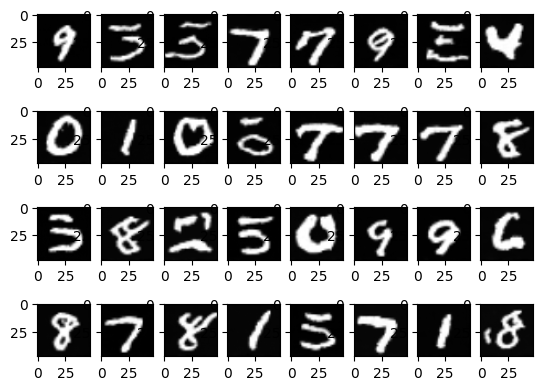

In [ ]:
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(sampled_images[i].cpu().detach().squeeze(0).squeeze(0), cmap='gray')

In [ ]:
diffusion.objective==''

False

In [ ]:
diffusion.model_predictions(batch)

TypeError: ignored

In [ ]:
#epochs = 10
#for i in range(epochs):
if __name__ == '__main__':
  num_classes = 10 #(0,1,2,3,4,5,6,7,8,9)

  model = Unet(
      dim = 48,
      dim_mults = (1, 2, 4, 8),
      num_classes = num_classes,
      channels = 1,
      cond_drop_prob = 0.5
  )

  diffusion = GaussianDiffusion(
      model,
      image_size = 48,
      timesteps = 200
  )#.cuda()

  #training_images = torch.randn(8, 3, 48, 48).cuda() # images are normalized from 0 to 1
  image_classes = torch.randint(0, num_classes, (8,))#.cuda()    # say 10 classes



  loss = diffusion(batch, classes = image_classes)
  print("Loss:", loss.item())
  loss.backward()

  # do above for many steps

  sampled_images = diffusion.sample(
      classes = image_classes,
      cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
  )

  sampled_images.shape # (8, 3, 128, 128)

  # interpolation

  interpolate_out = diffusion.interpolate(
      training_images[:1],
      training_images[:1],
      image_classes[:1]
  )

In [ ]:
sampled_images.shape

In [ ]:
a = sampled_images.cpu()[-1][0]

In [ ]:
a.shape

In [ ]:
for i in range(2):
  plt.subplot(2,2,i+1)
  plt.imshow(sampled_images.cpu()[i][-1], cmap='gray')
#plt.imshow(a, cmap='gray')

In [ ]:
for i in range(8):
    # 取得單張圖片
    img = sampled_images[i, 0, :, :]  # 由於是灰度圖，取得第一個通道

    # 顯示圖片
    plt.subplot(2, 4, i + 1)  # 2x4 的網格，第 i+1 張圖
    plt.imshow(img, cmap='gray')  # 使用灰度色彩映射
    plt.axis('off')  # 不顯示坐標軸